# Step1: Importing Data and Libraries

In [1]:
!git clone https://github.com/bardiarms/gan-rl.git
%cd gan-rl

fatal: destination path 'gan-rl' already exists and is not an empty directory.
/content/gan-rl


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torch torchvision torchaudio tqdm matplotlib pandas pillow

In [4]:
DATA_DIR = "/content/drive/MyDrive/gan-rl-data"
RUN_DIR  = "/content/drive/MyDrive/gan-rl-runs"

In [5]:
!ls -la "$DATA_DIR"

total 0
lrw------- 1 root root 0 Dec 19 11:37 cartoonset100k -> /content/drive/.shortcut-targets-by-id/1l-9xzrKNZUKfWTFGh0SRZe9j1HKLRRqJ/cartoonset100k


In [6]:
REPO_DIR = "/content/gan-rl"

In [7]:
import os

In [8]:
os.makedirs(RUN_DIR, exist_ok=True)
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("RUN_DIR:", RUN_DIR)

DATA_DIR exists: True
RUN_DIR: /content/drive/MyDrive/gan-rl-runs


In [9]:
DATA_ROOT = "/content/drive/MyDrive/gan-rl-data/cartoonset100k"

# Step2: Data Preprocessing

### Enumerate image-metadata paris

In [10]:
from pathlib import Path


In [11]:
data_root = Path(DATA_ROOT)

pairs, missing_meta, missing_img = [], [], []

for d in sorted(data_root.iterdir()):

    for png_path in d.glob("*.png"):
        csv_path = png_path.with_suffix(".csv")
        if csv_path.exists():
            pairs.append((str(png_path), str(csv_path), int(d.name)))   # If the pair exists, add them to pairs
        else:
            missing_meta.append(str(png_path))


print("Total pairs:", len(pairs))
print("Missing CSV for PNG:", len(missing_meta))

Total pairs: 100000
Missing CSV for PNG: 17


In [12]:
for i in range(5):
    print(pairs[i])

('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12694632614924764393.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12694632614924764393.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12110888894984629978.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12110888894984629978.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12783151780612292884.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12783151780612292884.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1182038763634098519.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1182038763634098519.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1213446833171185255.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1213446833171185255.csv', 0)


In [13]:
pairs.sort(key=lambda x: x[0])  # sort by image path

In [14]:
# Assert we can open the first image + read first metadata line
from PIL import Image
import pandas as pd

img_path, meta_path, folder_id = pairs[0]
img = Image.open(img_path).convert("RGB")
df = pd.read_csv(meta_path, header=None, names=["attr", "value", "max"])

print("Sample folder:", folder_id)
print("Image size:", img.size)
print("Metadata shape:", df.shape)
print(df.head())

Sample folder: 0
Image size: (500, 500)
Metadata shape: (18, 3)
             attr  value  max
0       eye_angle      2    3
1      eye_lashes      1    2
2         eye_lid      1    2
3     chin_length      0    3
4  eyebrow_weight      0    2


In [15]:
# Read one metadata file
def read_meta_csv(meta_path: str) -> pd.DataFrame:
    df = pd.read_csv(meta_path, header=None, names=["attr", "value", "max"])
    # ensure types
    df["attr"] = df["attr"].astype(str)
    df["value"] = df["value"].astype(int)
    df["max"] = df["max"].astype(int)
    return df

In [16]:
# Buil a schema for one-hot encoding
def build_schema(pairs, max_files=20):
    # pairs: list of (img_path, meta_path, folder_id)
    attr_to_num_classes = {}  # attr -> (max+1)
    attr_order = []           # stable order of attrs as discovered

    for i, (_, meta_path, _) in enumerate(pairs[:max_files]):
        df = read_meta_csv(meta_path)
        for _, row in df.iterrows():
            attr = row["attr"]
            num_classes = row["max"] + 1

            if attr not in attr_to_num_classes:
                attr_to_num_classes[attr] = num_classes
                attr_order.append(attr)
            else:
                # keep the maximum seen (in case some files differ)
                attr_to_num_classes[attr] = max(attr_to_num_classes[attr], num_classes)

    # offsets for packing one big vector
    offsets = {}
    total_dim = 0
    for attr in attr_order:
        offsets[attr] = total_dim
        total_dim += attr_to_num_classes[attr]

    return attr_order, attr_to_num_classes, offsets, total_dim

In [17]:
attr_order, attr_to_num_classes, offsets, meta_dim = build_schema(pairs)
print("num attributes:", len(attr_order))
print("meta vector dim:", meta_dim)
print(attr_order[:])

num attributes: 18
meta vector dim: 235
['eye_angle', 'eye_lashes', 'eye_lid', 'chin_length', 'eyebrow_weight', 'eyebrow_shape', 'eyebrow_thickness', 'face_shape', 'facial_hair', 'hair', 'eye_color', 'face_color', 'hair_color', 'glasses', 'glasses_color', 'eye_slant', 'eyebrow_width', 'eye_eyebrow_distance']


In [18]:
# Freeze the schema (Run Once)

import json

schema = {
    "attr_order": attr_order,
    "attr_to_num_classes": attr_to_num_classes,
    "offsets": offsets,
    "total_dim": meta_dim,
}

SCHEMA_PATH = "/content/drive/MyDrive/gan-rl-runs/meta_schema.json"
os.makedirs(os.path.dirname(SCHEMA_PATH), exist_ok=True)

with open(SCHEMA_PATH, "w") as f:
    json.dump(schema, f, indent=2)

print("Saved:", SCHEMA_PATH)

Saved: /content/drive/MyDrive/gan-rl-runs/meta_schema.json


### Resizing and normalization

In [19]:
from torchvision import transforms

In [32]:

IMG_SIZE = 128      # We convert 500*500 pixel images into 128*128.
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

In [33]:
import torch
import numpy as np

In [34]:
# Read metadata and store them in pandas dataframe
def read_meta(meta_path: str)-> pd.DataFrame:

  df = pd.read_csv(meta_path, header=None, names=["attr", "value", "max"])
  df["attr"] = df["attr"].astype(str)
  df["value"] = df["value"].astype(int)
  df["max"] = df["max"].astype(int)

  return df

In [35]:
# Apply one-hot encoding
def encode_onehot(meta_path: str,
                  attr_to_num_classes: dict,
                  offsets: dict,
                  total_dim: int
                  )-> torch.Tensor:

    df = read_meta(meta_path)
    vec = np.zeros((total_dim,), dtype=np.float32)

    for _, row in df.iterrows():
        attr = row["attr"]
        val = int(row["value"])

        if attr not in offsets:
          continue

        n = attr_to_num_classes[attr]
        if val < 0 or val >= n:
            val = max(0, min(val, n - 1))

        vec[offsets[attr] + val] = 1.0

    return torch.from_numpy(vec)


### Create Dataset (image, metadata one-hot)

In [36]:
from torch.utils.data import Dataset

In [37]:
class CartoonSetDataset(Dataset):

    def __init__(self,
                 pairs: list,
                 img_transform,
                 attr_to_num_classes: dict,
                 offsets: dict,
                 total_dim: int
                 ):
        self.pairs = pairs
        self.img_transform = img_transform
        self.attr_to_num_classes = attr_to_num_classes
        self.offsets = offsets
        self.total_dim = total_dim

    def __len__(self)-> int:
        return len(self.pairs)

    def __getitem__(self, idx: int)-> tuple:

        img_path, meta_path, folder_id = self.pairs[idx]

        img = Image.open(img_path).convert("RGB")
        img = self.img_transform(img)

        meta = encode_onehot(meta_path, self.attr_to_num_classes, self.offsets, self.total_dim)

        return img, meta, folder_id

### Build Dataloader

In [38]:
from torch.utils.data import DataLoader

In [39]:
ds = CartoonSetDataset(
    pairs=pairs,
    img_transform=img_transform,
    attr_to_num_classes=attr_to_num_classes,
    offsets=offsets,
    total_dim=meta_dim
)

dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
imgs, metas, folder_ids = next(iter(dl))
print("imgs:", imgs.shape, imgs.min().item(), imgs.max().item())
print("metas:", metas.shape, metas.min().item(), metas.max().item())
print("folder_ids:", folder_ids[:8])
print("meta sums (first 8):", metas[:8].sum(dim=1))

imgs: torch.Size([64, 3, 128, 128]) -1.0 1.0
metas: torch.Size([64, 235]) 0.0 1.0
folder_ids: tensor([6, 6, 0, 9, 1, 8, 8, 6])
meta sums (first 8): tensor([18., 18., 18., 18., 18., 18., 18., 18.])


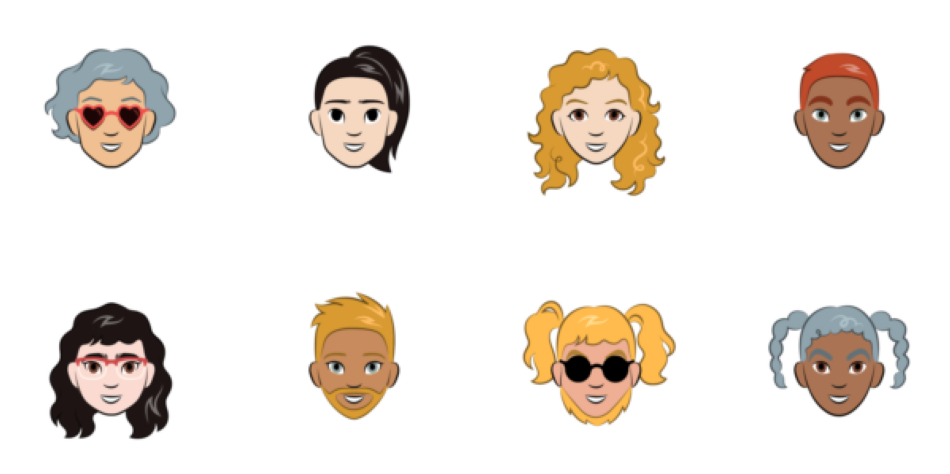

In [40]:
# Visualize a few images
import matplotlib.pyplot as plt

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

x = denorm(imgs[:8])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i].permute(1,2,0))
    plt.axis("off")
plt.show()